In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os, glob
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
def load_dataset_from_structure(root_path):
    data = []
    for file in root_path.glob('*/*/*.csv'):
        try:
            df = pd.read_csv(file)

            category = file.parents[1].name  # DDoS, DoS, etc.
            attack = file.parent.name        # DDoS ICMP, DoS TCP, etc.
            label_class = 'Benign' if category.upper() == 'BENIGN' else 'Attack'

            df['category'] = category
            df['attack'] = attack
            df['class'] = label_class

            data.append(df)
        except Exception as e:
            print(f"[ERROR] Failed to read file {file}: {e}")
    return pd.concat(data, ignore_index=True)

# Load train
train_root = Path('../../../Data/CICIoMT2024/train')
train_df = load_dataset_from_structure(train_root)

# Load test
test_root = Path('../../../Data/CICIoMT2024/test')
test_df = load_dataset_from_structure(test_root)

# Cek ringkasan
print("Train set:", train_df.shape)
print(train_df[['category', 'attack', 'class']].value_counts())
print("\nTest set:", test_df.shape)
print(test_df[['category', 'attack', 'class']].value_counts())

# Gabungkan train dan test menjadi satu DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

Train set: (7160831, 48)
category  attack              class 
DDoS      DDoS UDP            Attack    1635956
          DDoS ICMP           Attack    1537476
          DDoS TCP            Attack     804465
          DDoS SYN            Attack     801962
DoS       DoS UDP             Attack     566950
          DoS SYN             Attack     441903
          DoS ICMP            Attack     416292
          DoS TCP             Attack     380384
BENIGN    BENIGN              Benign     192732
MQTT      DDoS Connect Flood  Attack     173036
RECON     Port Scan           Attack      83981
MQTT      DoS Publish Flood   Attack      44376
          DDoS Publish Flood  Attack      27623
RECON     OS Scan             Attack      16832
SPOOFING  SPOOFING            Attack      16047
MQTT      DoS Connect Flood   Attack      12773
          Malformed Data      Attack       5130
RECON     Recon VulScan       Attack       2173
          Ping Sweep          Attack        740
Name: count, dtype: int64


In [3]:
# Bersihkan kolom attack agar tidak ada kesalahan pencocokan label
df['attack'] = df['attack'].astype(str).str.strip().str.upper()

# === Simulasi Zero-Day: Keluarkan salah satu attack dari training ===
zero_day_class = 'SPOOFING'

# Test = hanya kelas SPOOFING
test_zero_day = df[df['attack'] == zero_day_class].copy()
# Train = semua data kecuali SPOOFING
train_zero_day = df[df['attack'] != zero_day_class].copy()

# === Preprocessing ===
# Gunakan hanya fitur numerik
X = train_zero_day.select_dtypes(include='number').drop(columns=['class', 'category', 'attack'], errors='ignore')
y = train_zero_day['attack']

# Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Scaling fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split untuk validasi internal
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)

In [4]:
# === Bangun dan Latih DNN ===
dnn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/10
87573/87573 ━━━━━━━━━━━━━━━━━━━━ 152s 2ms/step - accuracy: 0.7728 - loss: 0.5185 - val_accuracy: 0.7915 - val_loss: 0.4608
Epoch 2/10
87573/87573 ━━━━━━━━━━━━━━━━━━━━ 149s 2ms/step - accuracy: 0.7875 - loss: 0.4731 - val_accuracy: 0.7928 - val_loss: 0.4567
Epoch 3/10
87573/87573 ━━━━━━━━━━━━━━━━━━━━ 139s 2ms/step - accuracy: 0.7886 - loss: 0.4702 - val_accuracy: 0.7852 - val_loss: 0.4626
Epoch 4/10
87573/87573 ━━━━━━━━━━━━━━━━━━━━ 141s 2ms/step - accuracy: 0.7887 - loss: 0.4705 - val_accuracy: 0.7953 - val_loss: 0.4524
Epoch 5/10
87573/87573 ━━━━━━━━━━━━━━━━━━━━ 140s 2ms/step - accuracy: 0.7897 - loss: 0.4699 - val_accuracy: 0.7947 - val_loss: 0.4528
Epoch 6/10
87573/87573 ━━━━━━━━━━━━━━━━━━━━ 142s 2ms/step - accuracy: 0.7901 - loss: 0.4690 - val_accuracy: 0.7941 - val_loss: 0.4519
Epoch 7/10
87573/87573 ━━━━━━━━━━━━━━━━━━━━ 141s 2ms/step - accuracy: 0.7903 - loss: 0.4705 - val_accuracy: 0.7942 - val_loss: 0.4540
Epoch 8/10
87573/87573 ━━━━━━━━━━━━━━━━━━━━ 142s 2ms/step - ac

556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step

📊 Prediksi model terhadap data SPOOFING (zero-day):
Counter({'BENIGN': 17721, 'MALFORMED DATA': 60, 'PORT SCAN': 5, 'DOS PUBLISH FLOOD': 1, 'OS SCAN': 1, 'DOS UDP': 1, 'DOS TCP': 1, 'DDOS ICMP': 1})


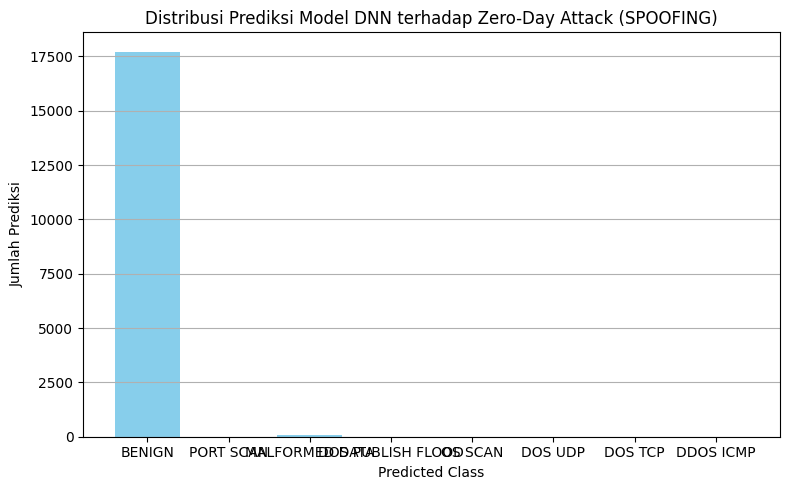

In [5]:
# === Uji pada data zero-day ===
X_spoof = test_zero_day.select_dtypes(include='number').drop(columns=['class', 'category', 'attack'], errors='ignore')
X_spoof_scaled = scaler.transform(X_spoof)

# Prediksi dan transformasi label
y_spoof_pred = np.argmax(dnn.predict(X_spoof_scaled), axis=1)
y_spoof_label = le.inverse_transform(y_spoof_pred)

# === Distribusi prediksi ===
print("\n📊 Prediksi model terhadap data SPOOFING (zero-day):")
print(Counter(y_spoof_label))

# === Visualisasi distribusi prediksi terhadap data SPOOFING ===
pred_counter = Counter(y_spoof_label)
plt.figure(figsize=(8, 5))
plt.bar(pred_counter.keys(), pred_counter.values(), color='skyblue')
plt.title('Distribusi Prediksi Model DNN terhadap Zero-Day Attack (SPOOFING)')
plt.xlabel('Predicted Class')
plt.ylabel('Jumlah Prediksi')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

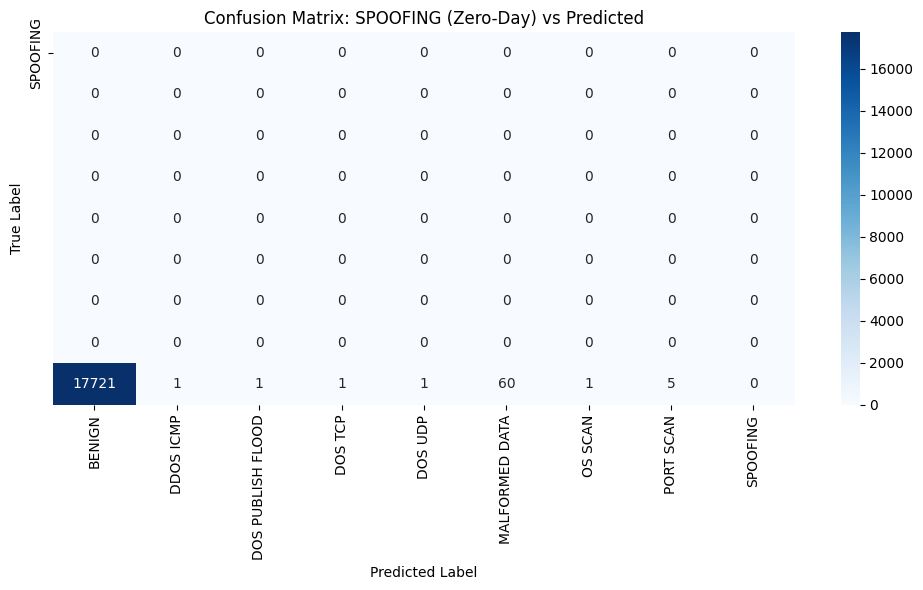


Classification Report (SPOOFING as Zero-Day):
                   precision    recall  f1-score   support

           BENIGN       0.00      0.00      0.00       0.0
        DDOS ICMP       0.00      0.00      0.00       0.0
DOS PUBLISH FLOOD       0.00      0.00      0.00       0.0
          DOS TCP       0.00      0.00      0.00       0.0
          DOS UDP       0.00      0.00      0.00       0.0
   MALFORMED DATA       0.00      0.00      0.00       0.0
          OS SCAN       0.00      0.00      0.00       0.0
        PORT SCAN       0.00      0.00      0.00       0.0
         SPOOFING       0.00      0.00      0.00   17791.0

         accuracy                           0.00   17791.0
        macro avg       0.00      0.00      0.00   17791.0
     weighted avg       0.00      0.00      0.00   17791.0



In [6]:
# === Confusion Matrix dan Classification Report ===
y_true = [zero_day_class] * len(y_spoof_label)
y_labels = np.unique(np.concatenate([y_true, y_spoof_label]))
cm = confusion_matrix(y_true, y_spoof_label, labels=y_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_labels, yticklabels=[zero_day_class], cmap='Blues')
plt.title('Confusion Matrix: SPOOFING (Zero-Day) vs Predicted')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_spoof_label, output_dict=False, zero_division=0)
print("\nClassification Report (SPOOFING as Zero-Day):")
print(report)